<a href="https://colab.research.google.com/github/basselkassem/nlp-toolkit/blob/master/bert_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install libs

In [1]:
# !pip install transformers
! pip install tensorflow_text

     |████████████████████████████████| 3.4MB 9.2MB/s 


# Import Libs

In [2]:
#from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
import tensorflow_hub as tfhub
import tensorflow_text as tftxt
import tensorflow_datasets as tfds
import os

# Load Data

In [5]:
dataset, info = tfds.load(
    'sentiment140',
    as_supervised = True,
    with_info = True, 
    data_dir = 'data',
)

Shuffling and writing examples to data/sentiment140/1.0.0.incomplete2XVA40/sentiment140-train.tfrecord


Shuffling and writing examples to data/sentiment140/1.0.0.incomplete2XVA40/sentiment140-test.tfrecord


Dataset sentiment140 downloaded and prepared to data/sentiment140/1.0.0. Subsequent calls will reuse this data.


In [6]:
train_ds = dataset['train']
test_ds = dataset['test']

In [7]:
for txt, lbl in train_ds.take(10).as_numpy_iterator():
  print(txt, lbl)


b"i'm 10x cooler than all of you! " 4
b'O.kk? Thats weird I cant stop following people on twitter... I have tons of people to unfollow ' 0
b'what a beautiful day not to got to my first class ' 4
b".@HildyGottlieb &amp; I was just saying to Maha'al yesterday, everything we ever needed to know was in Beatles' lyrics - you prove my point! " 4
b'kinda sad and confused  why do guys do this?' 0
b'@Real_DavidCook YES &amp; YES ' 4
b"@GDGOfficial But it's another beautiful day here in europe, you have to make the most of it  Rock the house again tonight!" 4
b'Working through hundreds of assignments ' 0
b'driving with the moonroof and windows open is THE BEST THING IN THE WORLD. Sitting on the couch with @melissasmirn she hates my hamster ' 0
b"@scott_mills Gutted! I worked for the fringe last year, won't be back this year " 0


In [8]:
def remove_neutral(txt, label):
  return label != 2

train_ds = train_ds.filter(remove_neutral)
test_ds = test_ds.filter(remove_neutral)

In [9]:
def normalize_labels(txt, label):
  new_label = 0

  if label == 4:
    new_label = 1
  else:
    new_label = 0
  return txt, new_label
train_ds = train_ds.map(normalize_labels)
test_ds = test_ds.map(normalize_labels)

In [10]:
train_ds = train_ds.batch(64, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

# Model defintion

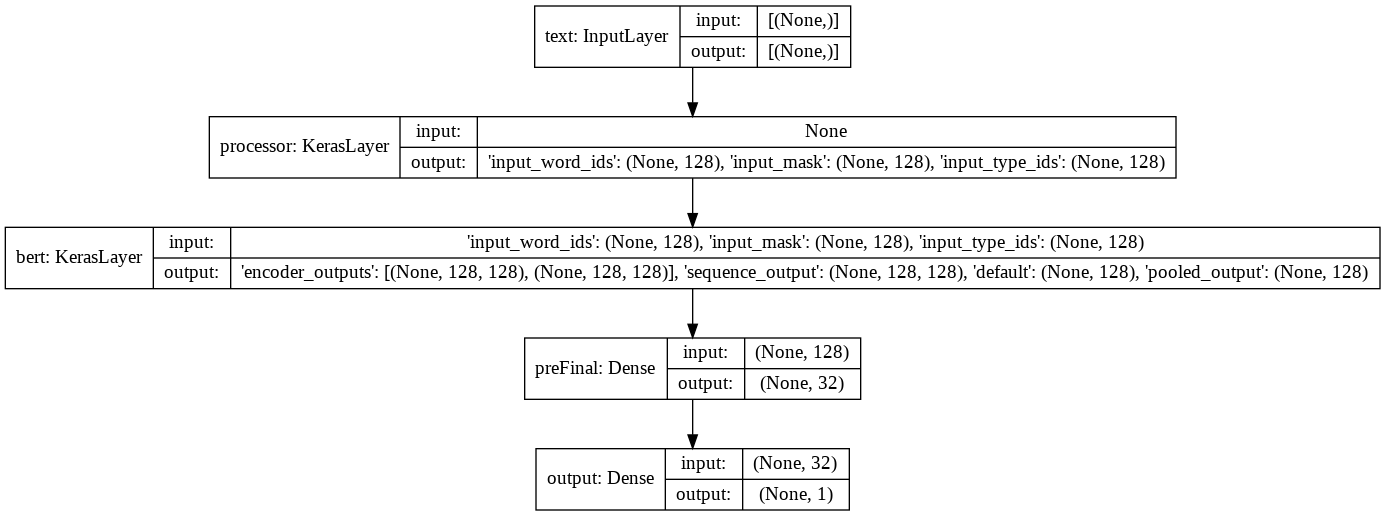

In [12]:
def get_model():
  model_handler = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'
  bert_module = tfhub.KerasLayer(model_handler, trainable = True, name = 'bert')

  processor_handler = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
  processor_module = tfhub.KerasLayer(processor_handler, name = 'processor')

  model_in = tf.keras.layers.Input(shape=(), dtype = tf.string,  name='text') 
  model_h = processor_module(model_in)
  model_h = bert_module(model_h, )
  model_h = tf.keras.layers.Dense(32, activation = 'relu', name = 'preFinal') (model_h['pooled_output'])
  model_out = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'output')(model_h)

  model = tf.keras.models.Model(model_in, model_out)
  model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
  return model

model = get_model()
tf.keras.utils.plot_model(model, show_shapes = True)

In [ ]:
history = model.fit(
    train_ds, validation_data = test_ds, epochs = 10, 
)

Epoch 1/10
   9012/Unknown - 1628s 181ms/step - loss: 0.4594 - accuracy: 0.7833

In [ ]:
model.evaluate(test_ds)